# Detection of middle ear events in Tinnitus patients polysomnographic data


In [1]:
#Only once when launching notebook
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')

import matplotlib.pyplot as plt
%matplotlib widget
print("Config loaded")

Config loaded


## Load, filter, and prepare data

In [2]:
import mne
from tinnsleep.config import Config
from tinnsleep.data import CreateRaw

filename = Config.bruxisme_files[36]  # load file from config
picks_chan = ['Airflow']           # subset of EMG electrodes
ch_types = ["misc"]

raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading
tmin = raw.times[0]                     
tmax = raw.times[-1]

raw  = CreateRaw(raw[picks_chan][0], picks_chan, ch_types=ch_types)        # pick channels and load

raw  = raw.filter(0.01, 5., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['Airflow'])
ch_names = raw.info["ch_names"]
print("Data filtered")
offset = raw.times[0]
print(f"keeping {(raw.times[-1]-raw.times[0])/3600:0.2f} hours of recording out of {(tmax-tmin)/3600:0.2f} hours")

Extracting EDF parameters from /Users/louis/Data/SIOPI/bruxisme/tom_mema.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-2-5e38b4f563f3>:9: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False)  # prepare loading


Data filtered
keeping 8.77 hours of recording out of 7.01 hours


## Epoching data

In [28]:
from tinnsleep.data import RawToEpochs_sliding

sfreq = raw.info["sfreq"]
window_length = 1                    # in seconds
duration = int(window_length * sfreq)   # in samples
interval = duration                     # no overlapping
epochs = RawToEpochs_sliding(raw, duration=duration, interval=interval)
print(f"Epochs done, shape {epochs.shape}")


Epochs done, shape (31562, 1, 200)


## Classifying epochs and annotate raw

In [31]:
from tinnsleep.classification import AmplitudeThresholding
from tinnsleep.signal import rms
from tinnsleep.data import CleanAnnotations, AnnotateRaw_sliding
import numpy as np

# compute the sum of power over electrodes and samples in each window
length_adaptive = 120 # in seconds
n_adaptive = int(length_adaptive / window_length) # in epochs
pipeline = AmplitudeThresholding(abs_threshold=0., rel_threshold=3, n_adaptive=n_adaptive)
X        = rms(epochs) # take only valid labels
labels   = pipeline.fit_predict(X)

print(f"bursts count: {np.sum(labels)}/{len(labels)} ({np.sum(labels) / len(labels) * 100:.2f}%)")
print(f"bursts time: {np.sum(labels) * window_length} seconds")

dict_annotations = {1: "MEA"}
annotations = []
for k, label in enumerate(labels):
    if label > 0:
        annotations.append(dict(
            onset=k*interval/sfreq,
            duration=duration/sfreq,
            description=dict_annotations[label],
            orig_time=offset
        )
            
        )
raw = CleanAnnotations(raw)
raw = AnnotateRaw_sliding(raw, labels, 
                dict_annotations=dict_annotations, duration=duration, interval=interval)
print("Raw annotated")

bursts count: 663/31562 (2.10%)
bursts time: 663 seconds
Raw annotated


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

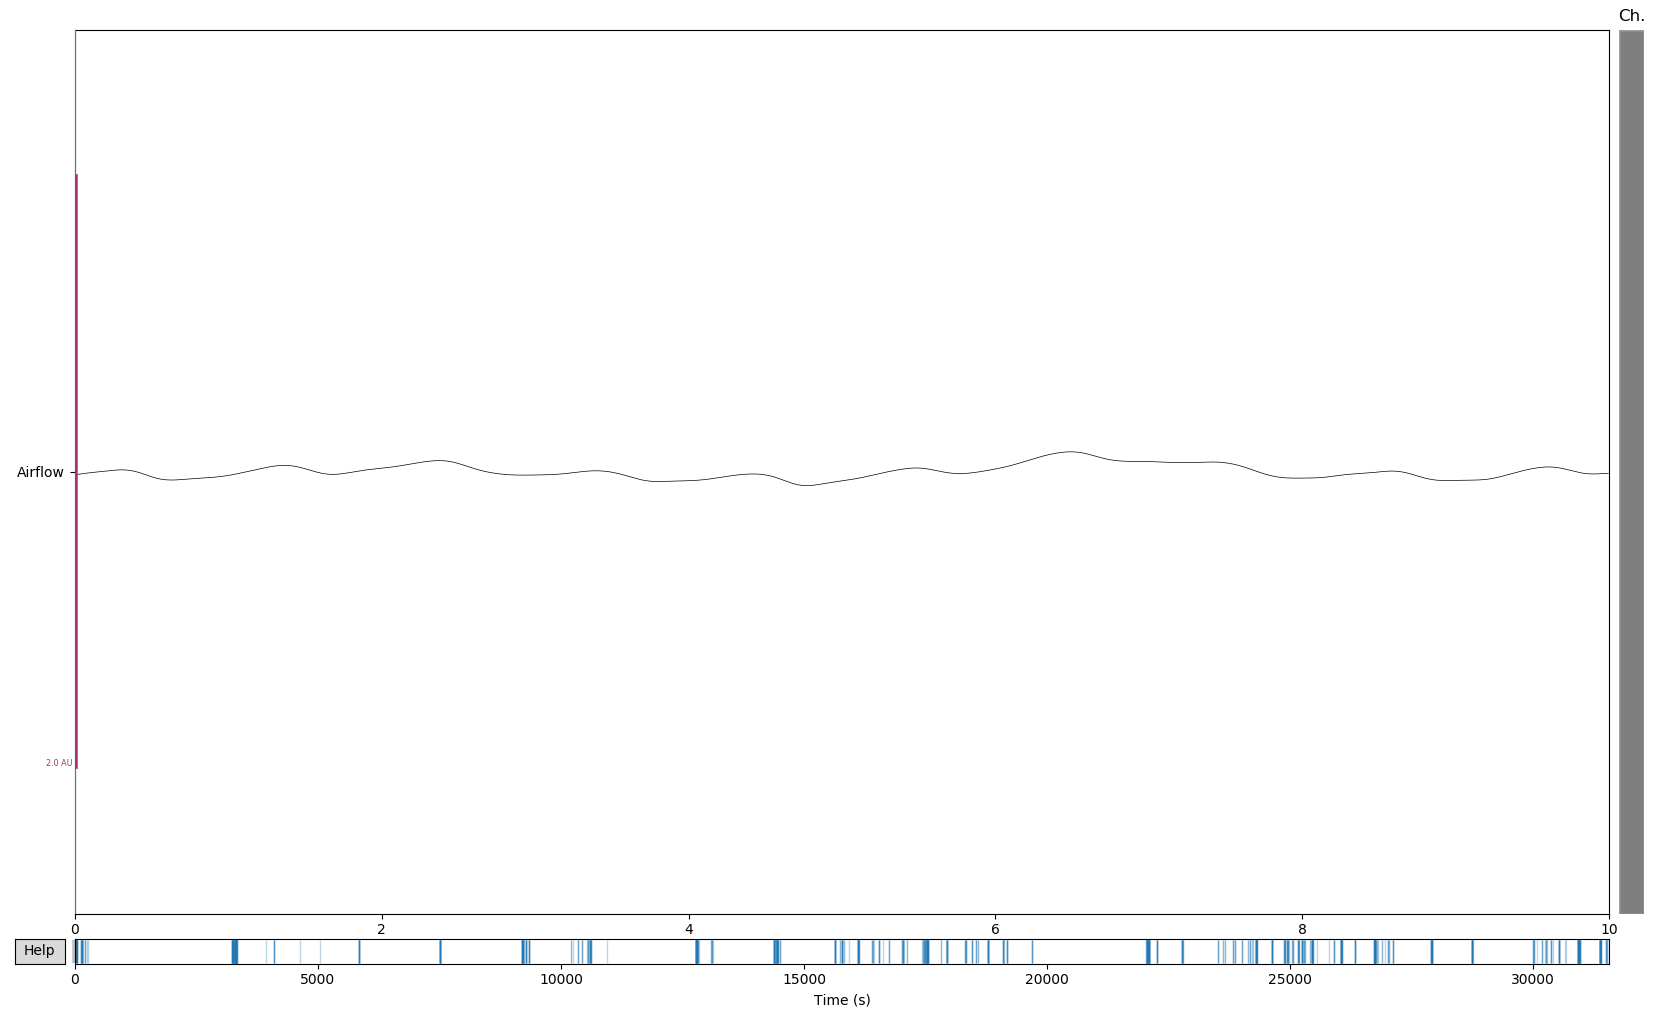

In [32]:
%matplotlib qt
scalings = dict(misc=1)
raw.plot(scalings = scalings)